In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

from cuml.manifold import TSNE

In [2]:
train_df = pd.read_csv('../data/input/train.csv', nrows=3 * 10**7)

In [3]:
def get_sparse_matrix(data, index: str, columns: str, values: str):

    data_ = data[[index, columns]].copy()

    if values == 'simple_count':
        data_[values] = 1
    else:
        data_[values] = data[values]

    data_.dropna(inplace=True)

    index_cate = CategoricalDtype(sorted(data_[index].unique()), ordered=True)
    columns_cate = CategoricalDtype(sorted(data_[columns].unique()), ordered=True)

    row = data_[index].astype(index_cate).cat.codes
    col = data_[columns].astype(columns_cate).cat.codes
    sparse_matrix = csr_matrix((data_[values], (row, col)),
                               shape=(index_cate.categories.size, columns_cate.categories.size))

    index_values = index_cate.categories.values
    columns_values = columns_cate.categories.values

    return sparse_matrix, index_values, columns_values

In [4]:
sparse_matrix, index_values, columns_values = get_sparse_matrix(train_df, index='content_id', columns='user_id', values='simple_count')

In [5]:
content_matrix = sparse_matrix.toarray()

In [6]:
tsne = TSNE(n_components=2, random_state=0)

In [7]:
tsne_array = tsne.fit_transform(content_matrix)

[W] [22:36:43.958374] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [8]:
tsne_array

array([[ 66.03532  ,  -6.832801 ],
       [ 55.745964 ,  -8.810115 ],
       [ 37.583054 , -14.119894 ],
       ...,
       [  3.389475 ,  14.718402 ],
       [  0.7763431,  41.474075 ],
       [ 22.13674  ,   4.9643283]], dtype=float32)

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

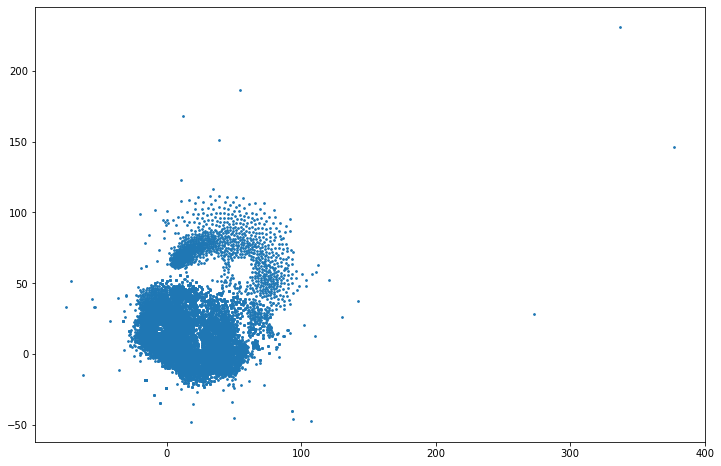

In [70]:
plt.figure(figsize=(12, 8))
plt.scatter(
    tsne_array[:, 0],
    tsne_array[:, 1],
    s=3)

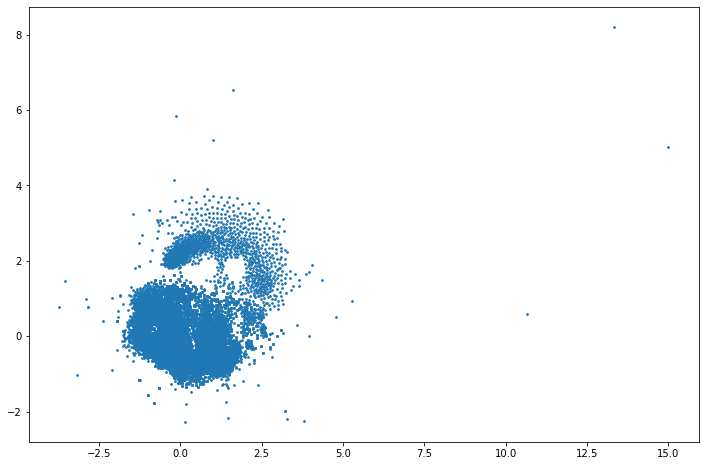

In [54]:
plt.figure(figsize=(12, 8))
plt.scatter(
    (tsne_array[:, 0] - tsne_array[:, 0].mean()) / tsne_array[:, 0].std(),
    (tsne_array[:, 1] - tsne_array[:, 1].mean()) / tsne_array[:, 1].std(),
    s=3)

In [11]:
for idx in range(len(tsne_array)):
    if tsne_array[idx, 0] <= -85:
        print(index_values[idx])

In [12]:
for idx in range(len(tsne_array)):
    if tsne_array[idx, 1] <= -70:
        print(index_values[idx])

In [16]:
tsne_array

array([[ 66.03532  ,  -6.832801 ],
       [ 55.745964 ,  -8.810115 ],
       [ 37.583054 , -14.119894 ],
       ...,
       [  3.389475 ,  14.718402 ],
       [  0.7763431,  41.474075 ],
       [ 22.13674  ,   4.9643283]], dtype=float32)

In [31]:
outlier_idx = np.argsort(np.sum((tsne_array - tsne_array.mean(0)) ** 2, axis=1))[-20:]
index_values[outlier_idx][::-1]

array([ 567,  721,  940, 1370,  362, 1241,  810,  286, 1108,  896,  670,
        711,  484,  681,  336, 1014, 1328,  456,  827, 1180])

In [71]:
d = []
for c in index_values[outlier_idx][::-1]:
    a = train_df[train_df['content_id'] == c]['answered_correctly']
    d.append(a.sum() / len(a))
    print(f'{c}          {len(a)},            {a.sum() / len(a)}')

567          2051,            0.893710385177962
721          16050,            0.6722118380062305
940          2319,            0.9034066407934455
1370          1894,            0.882259767687434
362          192,            0.78125
1241          2699,            0.6787699147832531
810          2646,            0.817838246409675
286          3548,            0.8866967305524239
1108          4791,            0.7332498434564809
896          4064,            0.7918307086614174
670          2861,            0.8164977280671094
711          5284,            0.8822861468584405
484          8290,            0.0353437876960193
681          2049,            0.9053196681307956
336          3130,            0.8348242811501597
1014          4190,            0.8322195704057279
1328          4015,            0.7519302615193026
456          4113,            0.8662776562120107
827          2730,            0.7981684981684982
1180          2231,            0.8991483639623488


<Figure size 1152x360 with 0 Axes>

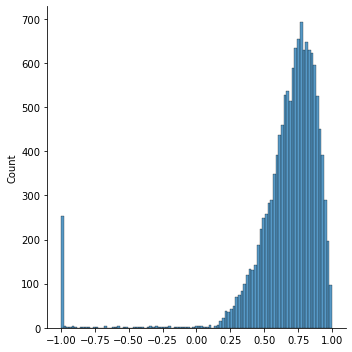

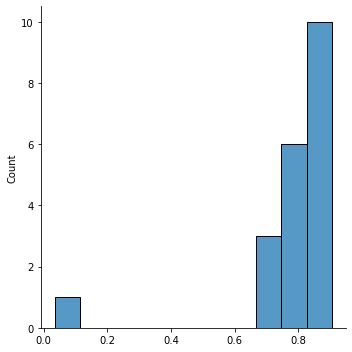

In [68]:
b = train_df.groupby('content_id')['answered_correctly'].mean().values

plt.figure(figsize=(16, 5))
sns.displot(b)
sns.displot(d)
plt.tight_layout()

In [74]:
tsne_array[1000: 1010]

array([[ 38.88345  ,  86.31854  ],
       [ 12.5769005,  71.13719  ],
       [  5.534002 ,  71.533325 ],
       [ 28.93338  ,  69.89347  ],
       [ 80.621765 ,  61.124252 ],
       [ 79.4078   ,  63.52566  ],
       [ 10.184715 ,  67.35951  ],
       [ 49.180943 ,  94.239876 ],
       [ 19.754156 ,  76.7151   ],
       [ 16.222528 , 108.70893  ]], dtype=float32)

In [81]:
question_df = pd.read_csv('../data/input/questions.csv')
question_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [82]:
c2p = dict(question_df[['question_id', 'part']].values)

In [83]:
tsne_df = pd.DataFrame({'content_id': index_values})

for idx in range(2):
    tsne_df[f'tsne_{idx}'] = tsne_array[:, idx]
    
tsne_df['part'] = tsne_df['content_id'].map(c2p)
tsne_df

,content_id,tsne_0,tsne_1,part
0,0,66.035316,-6.832801,1.0
1,1,55.745964,-8.810115,1.0
2,2,37.583054,-14.119894,1.0
3,3,35.635151,-11.867806,1.0
4,4,76.522957,13.592262,1.0
...,...,...,...,...
13765,32535,-16.057772,-18.033232,NaN
13766,32570,29.601789,22.027342,NaN
13767,32604,3.389475,14.718402,NaN
13768,32625,0.776343,41.474075,NaN


In [95]:
tsne_df[tsne_df['part'] == 1].head(200)

,content_id,tsne_0,tsne_1,part
0,0,66.035316,-6.832801,1.0
1,1,55.745964,-8.810115,1.0
2,2,37.583054,-14.119894,1.0
3,3,35.635151,-11.867806,1.0
4,4,76.522957,13.592262,1.0
...,...,...,...,...
195,195,27.749577,-3.028298,1.0
7850,7851,58.333698,-10.580994,1.0
7851,7852,59.150478,4.100572,1.0
7852,7853,53.533836,-2.046840,1.0


In [104]:
tsne_df[tsne_df['part'] == 2].head(1205)

,content_id,tsne_0,tsne_1,part
196,196,73.804352,43.454983,2.0
197,197,50.393394,46.934002,2.0
198,198,51.267864,69.764565,2.0
199,199,2.449778,66.100021,2.0
200,200,22.555929,69.266441,2.0
...,...,...,...,...
1396,1396,73.477180,56.229321,2.0
1397,1397,18.370083,73.170540,2.0
1398,1398,17.035948,80.622139,2.0
1399,1399,76.143799,63.127171,2.0


In [100]:
tsne_df[tsne_df['part'] == 3].head(500)

,content_id,tsne_0,tsne_1,part
1400,1400,53.259460,50.584122,3.0
1401,1401,53.271748,50.497650,3.0
1402,1402,53.403538,50.924660,3.0
1403,1403,46.123779,16.845646,3.0
1404,1404,46.202545,16.785952,3.0
...,...,...,...,...
1895,1895,43.786041,15.710768,3.0
1896,1896,43.767220,15.747352,3.0
1897,1897,43.773220,15.746441,3.0
1898,1898,44.978771,21.298994,3.0


In [105]:
tsne_df[tsne_df['part'] == 4].head(500)

,content_id,tsne_0,tsne_1,part
2554,2554,31.736071,2.992656,4.0
2555,2555,31.598257,2.903967,4.0
2556,2556,31.633930,2.825862,4.0
2557,2557,33.248219,0.725200,4.0
2558,2558,33.366711,0.742671,4.0
...,...,...,...,...
3049,3049,34.469753,0.255783,4.0
3050,3050,38.511436,14.891523,4.0
3051,3051,31.097300,8.494610,4.0
3052,3052,31.074667,8.361947,4.0


In [106]:
tsne_df[tsne_df['part'] == 5].head(500)

,content_id,tsne_0,tsne_1,part
3549,3549,-16.077423,-18.078053,5.0
3550,3550,6.129873,-1.984617,5.0
3551,3551,-16.076223,-18.073452,5.0
3552,3552,2.742504,15.028556,5.0
3553,3553,6.611385,35.716911,5.0
...,...,...,...,...
4044,4044,-7.799043,6.061529,5.0
4045,4045,-9.473301,4.090892,5.0
4046,4046,4.645461,-2.999605,5.0
4047,4047,1.061245,14.420754,5.0


In [107]:
tsne_df[tsne_df['part'] == 6].head(500)

,content_id,tsne_0,tsne_1,part
6480,6481,-1.015384,-23.969082,6.0
6481,6482,-1.018615,-23.971474,6.0
6482,6483,-1.018788,-23.968134,6.0
6483,6484,-1.018904,-23.964962,6.0
6484,6485,-1.017941,-23.971022,6.0
...,...,...,...,...
10092,10098,-1.012212,-23.935534,6.0
10093,10099,-1.011786,-23.938892,6.0
10094,10100,-1.010913,-23.932623,6.0
10095,10101,-1.007676,-23.930477,6.0


In [117]:
tsne_df[tsne_df['part'] == 7].head(925)

,content_id,tsne_0,tsne_1,part
6927,6928,-3.362082,48.415588,7.0
6928,6929,-3.376155,48.360825,7.0
6929,6930,-3.373213,48.364174,7.0
6930,6931,29.103334,41.334282,7.0
6931,6932,29.109985,41.401043,7.0
...,...,...,...,...
7847,7848,2.515494,15.458131,7.0
7848,7849,2.444252,15.425383,7.0
7849,7850,2.706645,15.513723,7.0
8013,8014,9.713485,47.155949,7.0


No handles with labels found to put in legend.


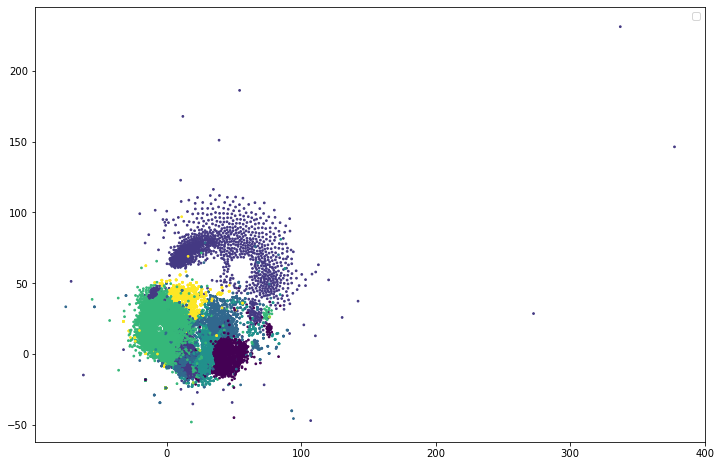

In [89]:
plt.figure(figsize=(12, 8))
plt.scatter(
    tsne_array[:, 0],
    tsne_array[:, 1],
    c=tsne_df['part'],
    s=3)

plt.legend()